In [107]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import re
import os
import json

import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer

from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.utils import pad_sequences, split_dataset
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split

# from functions import *

In [93]:
class Model():
    def __init__(self,
                 input_shape,
                 model_folder
                ):
        """
        model_folder argument is a folder where models' files will be saved 
        """
        self.model_folder = model_folder
        if not os.path.exists(self.model_folder):
            os.makedirs(self.model_folder)
            
        self.input_shape = input_shape
        
        
    def train(self, 
              batch_size,
              epochs,
              verbose,
              excel_file = r'data\sentences_tables.xlsx',
              embedding_file_path = r'model\model_embeddings.txt'
             ):
        """
        Argument excel_file is a path to an excel file which contains data for training a model. It should have 
        format such as 'data\sentences_tables.xlsx'.
        
        Argument embedding_file_path is a path to embedding file. This is a text file of following format:
        word1 x1 x2 x3
        word2 y1 y2 y3
        ...
        It contains words with their vector representation. This can be equal to for example 'glove.840B.300d.txt'
        which contains word embeddings from glove model but this file is huge, we need word embeddings only for 
        words which are present in out training dataset. In order to create word embedding file which contains
        only those words which are present in training data set we can use the function 'create_embedding_file'.
        """
        print(f'Training a model using {excel_file}\n')
        # self.create_tokenizer(excel_file = excel_file)
        self.create_training_data(excel_file = excel_file)
        self.create_embedding_matrix(vector_dimension = 300, 
                                     embedding_file_path = embedding_file_path
                                    )
        
        self.model = Sequential()
        self.model.add(Embedding(input_dim = self.embedding_matrix.shape[0], 
                                 output_dim = self.embedding_matrix.shape[1], 
                                 input_length = len(self.x_train[0]),
                                 weights = [self.embedding_matrix]
                                )
                      )
        self.model.add(LSTM(256, return_sequences = True))
        self.model.add(LSTM(128))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(64, activation = "relu"))
        self.model.add(Dense(len(self.y_train[0]), activation = "sigmoid"))

        self.model.compile(loss = 'binary_crossentropy', 
                           optimizer = Adam(learning_rate = 0.01),
                           metrics=['acc']
                          )
        
        history = self.model.fit(x = self.x_train,
                                 y = self.y_train,
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 verbose = verbose
                                )
        
        self.evaluate()
        self.model.save(os.path.join(self.model_folder, 'model'))
        
        return history
    
    
    def evaluate(self):
        score = self.model.evaluate(self.x_test, self.y_test, verbose = 0)
        print('loss for a test dataset: ', score[0])
        print('accuracy for a test dataset: ', score[1])
    
    
    def clean_text(self,
                   string: str, 
                   punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
                   stop_words = stopwords.words('english'),
                   # porter = PorterStemmer()
                   wnl = WordNetLemmatizer()
                  ):
        """
        A method to clean text. It removes punctuations, stop words, applies lemmatization.
        """
        # Removing the punctuations
        for x in string.lower(): 
            if x in punctuations: 
                string = string.replace(x, "") 

        # Converting the text to lower
        string = string.lower()

        # Removing stop words
        string = ' '.join([word for word in string.split() if word not in stop_words])

        # stemming/lemmatizing words. That means changing word to its basic format, for example
        # words 'fishing', 'fished', 'fischer' will be changed into a word 'fisch'
        # lemmatization should be better because stemming changes words too much, for example
        # business is changed into busi
        # string = ' '.join([porter.stem(word) for word in string.split()])
        string = ' '.join([wnl.lemmatize(word, pos = "v") for word in string.split()])

        # Cleaning the whitespaces
        string = re.sub(r'\s+', ' ', string).strip()

        return string
    
            
    def encode(self, y, all_unique_values):
        """
        y is a list of strings or numbers.
        all_unique_values is a list of all unique values which may appear in y.
        This function creates y_encoded which is a list of vectors where each
        element of that vector corresponds to one of the unique values from y. For example if index1 corresponds to 
        value1 (that means value1 = all_unique_values[index1]) and y[sample_number] = value1 then 
        y_encoded[sample_number][index1] = 1 and y_encoded[sample_number][index] = 0 for all indexes different then index1
        """
        y_encoded = np.array([[0 for i in range(len(all_unique_values))] for i in range(len(y))])
        for sample_number, value in enumerate(y):
            value_index = np.where(all_unique_values == value)[0][0]
            y_encoded[sample_number][value_index] = 1

        return y_encoded
                  
                  
    def create_training_data(self, excel_file):
        """
        Creating a training and testing datasets self.x_train, self.x_test, self.y_train, self.y_test. This function
        also creates and saves a tokenizer and a list of all unique tables names all_unique_values because when we load
        a ready model those values are needed for the 'predict' function.
        """
        sentences_tables = pd.read_excel(excel_file).values
        random.shuffle(sentences_tables)
        clean_sentences = np.array([self.clean_text(sentence) for sentence in sentences_tables[:, 0]])

        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(clean_sentences)

        self.all_unique_values = np.unique(sentences_tables[:, 1])

        y_str = sentences_tables[:, 1]
        y_encoded = self.encode(y_str, self.all_unique_values)

        # max_len = np.max([len(sentence.split()) for sentence in self.clean_sentences])
        sequences = self.tokenizer.texts_to_sequences(clean_sentences)
        # x = pad_sequences(sequences, maxlen = max_len)
        x = pad_sequences(sequences, maxlen = self.input_shape)
        
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y_encoded, test_size = 0.2)

        pd.DataFrame(self.all_unique_values).to_csv(os.path.join(self.model_folder, 'all_unique_values.csv'))
        with open(os.path.join(self.model_folder, 'tokenizer.json'), 'w') as file:
            json.dump(self.tokenizer.to_json(), file)
        
        
    def get_coefs(self, word, *arr): 
        return word, list(np.asarray(arr, dtype='float'))
        
        
    def create_embedding_file(self,
                              embedding_file1 = r'model\glove.840B.300d.txt', 
                              embedding_file2 = r'model\model_embeddings.txt'
                             ):
        """
        This function will create an embedding file called embedding_file2 which will contain only those words 
        from embedding_file1 which are present in the training dataset. If training dataset wasn't created yet
        then this function will create it.
        """
        # creating a training dataset if we didn't do that yet
        if not hasattr(self, 'tokenizer'):
            self.create_training_data()
        
        embeddings = dict(self.get_coefs(*o.split(" ")) for o in open(embedding_file1, errors = 'ignore'))
        with open(embedding_file2, 'w') as file:
            for word, index in self.tokenizer.word_index.items():
                word_vector = embeddings[word]
                line = ' '.join(np.concatenate([[word], word_vector]))
                file.write(line + '\n')
            
        
    def create_embedding_matrix(self,
                                vector_dimension,
                                embedding_file_path
                               ):
        """
        A function to create the embedding matrix. This is a matrix where each row is a vector representing a word.
        To create that matrix we use a word embedding file which path is equal to embedding_file_path.
        embedding_matrix[row_number] is a vector representation for a word = list(tokenizer.word_index.keys())[row_number - 1]
        First row of embedding_matrix are zeros. This matrix is needed to train a model.
        """
        embeddings = dict(self.get_coefs(*o.split(" ")) for o in open(embedding_file_path, errors = 'ignore'))

        # embedding_matrix[row_number] is a vector representation of a word = self.tokenizer.word_index.keys()[row_number - 1]
        # first row in embedding_matrix is 0
        self.embedding_matrix = np.zeros((len(self.tokenizer.word_counts) + 1, vector_dimension))
        for word, index in self.tokenizer.word_index.items():
            if index > len(self.tokenizer.word_counts):
                break
            else:
                try:
                    self.embedding_matrix[index] = embeddings[word]
                except:
                    continue
        
        
    def load_model(self):
        """
        Loading a ready model. This function loads also a tokenizer and list of all unique values in y
        which are needed for the 'predict' function.
        """
        self.model = load_model(os.path.join(self.model_folder, 'model'))
        
        # we need tokenizer so we can use 'predict' function
        with open(os.path.join(self.model_folder, 'tokenizer.json'), 'r') as file:
            self.tokenizer = tokenizer_from_json(json.load(file))
        
        # we need all_unique_values so we can use 'predict' function
        self.all_unique_values = pd.read_csv(os.path.join(self.model_folder, 'all_unique_values.csv'), index_col = 0).values.flatten()
        
        
    def predict(self, x):
        """
        x argument is a sentence.
        
        Returned prediction is a dataframe with all unique names of tables which were used for training a model
        with probabilities that those tables matches given sentence.
        """
        # remove stop words, special characters etc
        clean_sentence = self.clean_text(x)
        # change words into a numbers
        tokenized_sentence = self.tokenizer.texts_to_sequences([clean_sentence])
        # change sentence length
        tokenized_sentence = pad_sequences(tokenized_sentence, maxlen = self.input_shape)
        
        prediction = self.model.predict(tokenized_sentence).flatten()
        prediction = pd.concat((pd.DataFrame(self.all_unique_values), pd.DataFrame(prediction)), axis = 1)
        prediction.columns = ['table_name', 'probability']
        prediction = prediction.sort_values(by = 'probability', ascending = False)
        
        return prediction

In [96]:
model = Model(model_folder = 'model',
              input_shape = 15
             )

In [97]:
history = model.train(batch_size = 20,
                      epochs = 5,
                      verbose = 1
                     )

Training a model using data\sentences_tables.xlsx

Epoch 1/5
33/33 [==============================] - 5s 59ms/step - loss: 0.1875 - acc: 0.5015
Epoch 2/5
33/33 [==============================] - 2s 59ms/step - loss: 0.1030 - acc: 0.7163
Epoch 3/5
33/33 [==============================] - 2s 61ms/step - loss: 0.0612 - acc: 0.8420
Epoch 4/5
33/33 [==============================] - 3s 77ms/step - loss: 0.0424 - acc: 0.8773
Epoch 5/5
33/33 [==============================] - 3s 77ms/step - loss: 0.0391 - acc: 0.9080
loss for a test dataset:  0.030115071684122086
accuracy for a test dataset:  0.9329268336296082


INFO:tensorflow:Assets written to: model\model\assets


INFO:tensorflow:Assets written to: model\model\assets


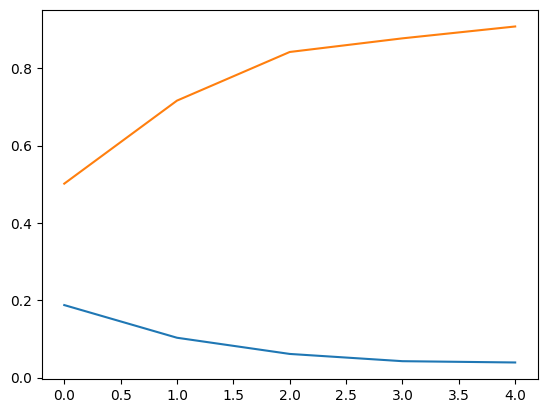

In [110]:
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

In [85]:
model.load_model()

In [101]:
model.predict('language name')

1/1 [==============================] - 0s 21ms/step


,table_name,probability
2,Stage.dbo.vw_CCH_V6a,0.566255
8,Stage.emp.tbl_Clients,0.095408
4,Stage.emp.tblLU_Offices,0.072665
0,Stage.dbi.LangMap,0.058131
7,Stage.emp.tblLU_TSProductivityMeasures,0.038585
1,Stage.dbi.PRTL_Vendor,0.029074
6,Stage.emp.tblLU_TSOperations,0.021186
3,Stage.emp.tblLU_Departments,0.013824
12,Stage.emp.tbl_Users,0.012043
5,Stage.emp.tblLU_TSOperationTypes,0.011787
